Given a and $\rho$, try to estimate G.  
1. New way to propose g:  
Denote $length(g) = dg$.  
z(g) = log(g[:-1]/g[-1]): $length(z) = dg-1$ and $z[i] = log(\frac{g[i]}{g[-1]})$.  
Propose $z^*~N(z, \sigma_g^2)$.  
Then return $z^*$ to $g^*$: $g^* = (e^{z^*_0},...,e^{z^*_{dg-2}},1)$ (normalized). 

2. Some components of g will goes to 0, then $(a*\rho_i-1)log(g_i)$ will become extremely large and dominate other terms. Then we will never accept the proposals unless we get a smaller $g_i$.  
Solution: define a value $infinity$ which is a small positive value. If the smallest component is smaller than $infinity$, we will add it to every component of g and then normalize it.  
For the choice of $infinity$, we hope it to be small enough to avoid unnecessary change. But if $infinity$ is too small, it will still lead to small accept rate.  
An acceptable value of $infinity$ is $10^{-5}$.

3. The choice of $\sigma_g^2$:  
$\sigma_g^2 = 1$: the error not converge.  
$\sigma_g^2 = 0.1$: accept rate = 0.4, converges within 500 iterations.  
$\sigma_g^2 = 0.01$: accept rate > 0.75, converges within 1000 iterations.  
$\sigma_g^2 = 0.005$: accept rate > 0.8, converges within 1500 iterations.

In [5]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart, dirichlet, expon, norm
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [6]:
def para_x(u, s2, tao):
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    return sx, mux 
def document_generator(a, rho, T, s2, tao, N):
    '''
    Given the corpus, generate more documents.
    All corpus-level parameters are given.
    N: the number of documents.
    
    output: 
    X: N*d, X[i] = document[i]
    Y: Y[i] = label[i]
    G: membership
    U: transformed membership
    '''

    nlabel = len(T) # number of y
    d = len(tao[0]) # dim(x)
    
    Y = np.random.choice(list(range(nlabel)),N) # labels
    G = np.random.dirichlet(a*rho,N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = []
    
    for i in range(N):
        sx, mux = para_x(U[i], s2, tao)
        X.append(np.random.multivariate_normal(mux, sx))
    X = np.array(X)

    return X, Y, G, U

def check_p(a, rho, mu, s_inv):
    '''
    Input: the parameters used in the data
    1. Check whether a and rho will generate extremely small g
    2. See distributions of different topics
    '''
    ntopic = len(mu)
    g = np.random.dirichlet(a*rho, 100)
#     print("The minimum component of g is",g.min())
    
    print("Distribution of pure types")
    s = [np.linalg.inv(i) for i in s_inv]
    pX = np.concatenate(tuple([np.random.multivariate_normal(mu[i], s[i], 100) for i in range(ntopic)]))
    pY = [[i]*100 for i in range(ntopic)]
    fig_pure_type = plt.figure()
    ax = Axes3D(fig_pure_type)
    ax.scatter(pX[:, 0], pX[:, 1], pX[:, 2], c = pY)
    plt.show()

In [39]:
def simplex_proposal(g, sigma):
    '''
    g is in simplex
    z[i] = log g[i]/g[-1]
    draw newz~N(z, sigma*I)
    newz -> newg
    '''
    z = np.log(g[:-1]/g[-1])
    newz = np.random.multivariate_normal(z, sigma*np.eye(len(z)))
    newg = np.exp(np.append(newz,0))
    newg /= newg.sum()
    return newg

def px(x, u, s2, tao):
    # return 0.5*log|lambda_x|-0.5(x-mux)^T*lambda_x*(x-mux)
    
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    
    return 0.5*np.log(np.linalg.det(lambdax))-0.5*np.dot(np.dot((x-mux).T, lambdax), x-mux)


def gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave, a,rho):
    '''
    Input:
        Data: X and Y
        hyper(fixed): alpha, b
        para: T, s2, tao
        Tuning parameter: sigmaa, sigmarho, sigmag
        # For comparing: a, rho, G
        After nconverge times, start saving samples
        nskip:  block size for each saved state
        nsave: number of saved states
    
    Output:
        Gs, as, rhos: the saved states 
        arG, arrho, ara: accept rate list during every nskip iterations
        the length of all these variables = nsave + 1
    '''
    
    
    nlabel = len(T)
    dg = len(alpha)
    ntopic = len(T[0])
    d = len(X[0])
    N = len(Y)  
    
    infinity = 10**(-5) # To avoid overflow, if we get g or rho smaller than this
    
    
    # initialization
    rho1 = np.random.dirichlet(np.ones(dg), 1)[0]
    rho1 = rho.copy()
    G1 = np.random.dirichlet(np.ones(dg), N)
#     a1 = np.random.exponential(1/b,1)[0]    
    a1 = a
    probx = [px(X[i], np.dot(T[Y[i]], G1[i]), s2, tao) for i in range(N)]
    
    asave, Gs, rhos, ara, arG, arrho = [], [], [], [], [], [] # estimates and accept rates
    ca = cg = crho = 0 # count of accepted proposals
    
    for t in range(nconverge):
        # update G
        for i in range(N):
            oldg = G1[i]
            newg = simplex_proposal(oldg, sigmag)
            if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
            newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
            oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
            newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
            
            ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
            if np.random.uniform() < ag:
                G1[i] = newg # update G
                probx[i] = newpx # update px
                cg += 1
            
    asave.append(a1)
    Gs.append(G1.copy())
    rhos.append(rho1.copy())
    ara.append(ca/nconverge)
    arG.append(cg/nconverge/N)
    arrho.append(crho/nconverge)
    
    
    for step in range(nsave):
        ca = cg = crho = 0
        
        for t in range(nskip):
        # update G
            for i in range(N):
                oldg = G1[i]
                newg = simplex_proposal(oldg, sigmag)
                if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
                newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
                oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
                newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                if np.random.uniform() < ag:
                    G1[i] = newg # update G
                    probx[i] = newpx # update px
                    cg += 1


        Gs.append(G1.copy())
        arG.append(cg/nskip/N)    
    
    return asave, Gs, rhos, ara, arG, arrho

the value of a: 15.547761093479659


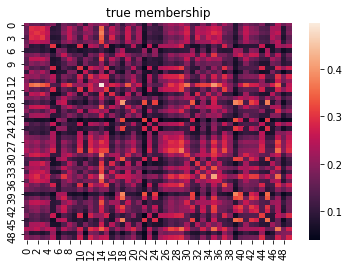

Distribution of pure types


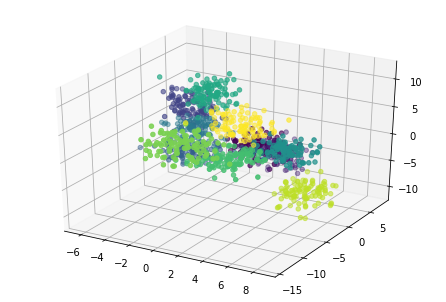

In [9]:
# set parameters
d = 30
k0, k1 = 2,5
nlabel = 3
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  50, 1,1,1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
trueU = sns.heatmap(np.dot(U,U.T))
plt.title("true membership")
plt.show()
check_p(a, rho, mu, s_inv)

In [41]:
asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, 0.001, 10, nskip=10, nsave=500,a=a,rho = rho)

accept rate of a, G and rho for the last iteration: 0.92
ave error G: 0.3276945986280568
P(difference<0.5)= 0.9
P(difference<0.4)= 0.74
P(difference<0.3)= 0.48
P(difference<0.2)= 0.12
P(difference<0.1)= 0.0


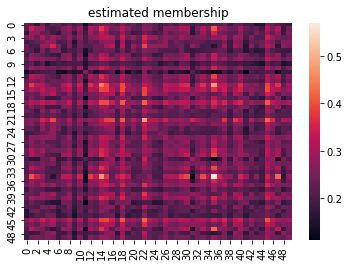

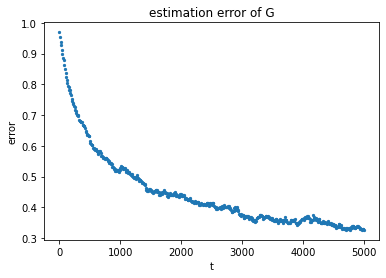

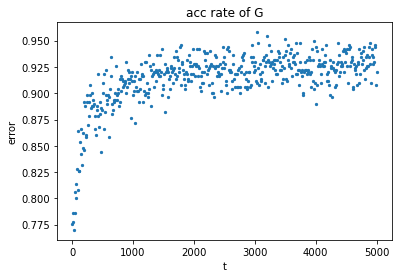

In [42]:
nsave = len(Gs)-1
nskip = 10
print("accept rate of a, G and rho for the last iteration:",arG[-1])
G1 = Gs[-1]
print("ave error G:", (abs(G-G1)).sum()/N)

differenceG = abs(G-G1).sum(axis=1)
error_summary_G = []
for tt in range(5,0,-1):
    tem = tt/10
    error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/50)
    print("P(difference<"+str(tem)+")=", error_summary_G[-1])

eU = sns.heatmap(np.dot(G1,G1.T))
plt.title("estimated membership")
plt.show()

errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
plt.scatter([i*nskip for i in range(nsave+1)], errorG, s=5)
plt.title("estimation error of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

plt.scatter([i*nskip for i in range(nsave+1)], arG, s=5)
plt.title("acc rate of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

accept rate of a, G and rho for the last iteration: 0.8320000000000001
ave error G: 0.3179834976324641
P(difference<0.5)= 0.92
P(difference<0.4)= 0.82
P(difference<0.3)= 0.5
P(difference<0.2)= 0.1
P(difference<0.1)= 0.02


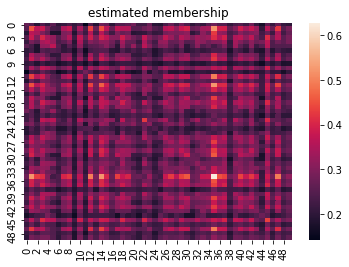

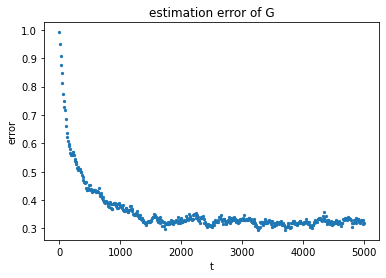

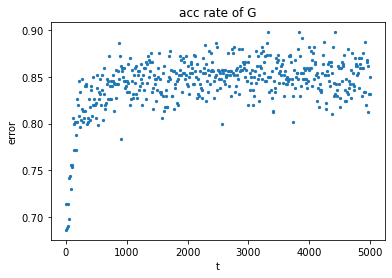

In [43]:
asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, 0.005, 10, nskip=10, nsave=500,a=a,rho = rho)
nsave = len(Gs)-1
nskip = 10
print("accept rate of a, G and rho for the last iteration:",arG[-1])
G1 = Gs[-1]
print("ave error G:", (abs(G-G1)).sum()/N)

differenceG = abs(G-G1).sum(axis=1)
error_summary_G = []
for tt in range(5,0,-1):
    tem = tt/10
    error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/50)
    print("P(difference<"+str(tem)+")=", error_summary_G[-1])

eU = sns.heatmap(np.dot(G1,G1.T))
plt.title("estimated membership")
plt.show()

errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
plt.scatter([i*nskip for i in range(nsave+1)], errorG, s=5)
plt.title("estimation error of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

plt.scatter([i*nskip for i in range(nsave+1)], arG, s=5)
plt.title("acc rate of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

accept rate of a, G and rho for the last iteration: 0.84
ave error G: 0.3402376780710374
P(difference<0.5)= 0.92
P(difference<0.4)= 0.68
P(difference<0.3)= 0.34
P(difference<0.2)= 0.14
P(difference<0.1)= 0.02


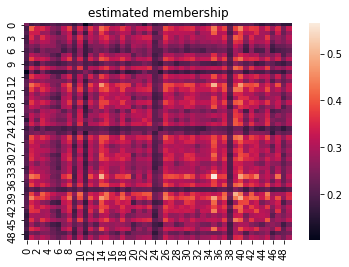

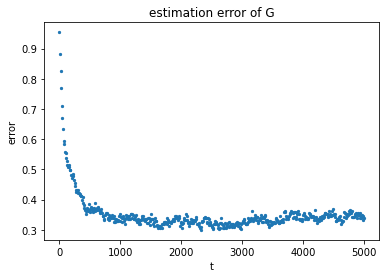

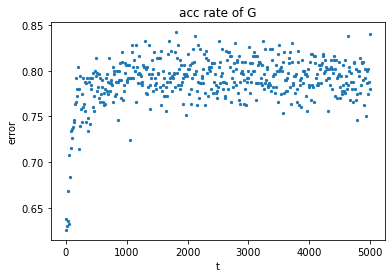

In [44]:
asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, 0.01, 10, nskip=10, nsave=500,a=a,rho = rho)
nsave = len(Gs)-1
nskip = 10
print("accept rate of a, G and rho for the last iteration:",arG[-1])
G1 = Gs[-1]
print("ave error G:", (abs(G-G1)).sum()/N)

differenceG = abs(G-G1).sum(axis=1)
error_summary_G = []
for tt in range(5,0,-1):
    tem = tt/10
    error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/50)
    print("P(difference<"+str(tem)+")=", error_summary_G[-1])

eU = sns.heatmap(np.dot(G1,G1.T))
plt.title("estimated membership")
plt.show()

errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
plt.scatter([i*nskip for i in range(nsave+1)], errorG, s=5)
plt.title("estimation error of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

plt.scatter([i*nskip for i in range(nsave+1)], arG, s=5)
plt.title("acc rate of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

accept rate of a, G and rho for the last iteration: 0.562
ave error G: 0.34936890047562114
P(difference<0.5)= 0.82
P(difference<0.4)= 0.66
P(difference<0.3)= 0.38
P(difference<0.2)= 0.14
P(difference<0.1)= 0.0


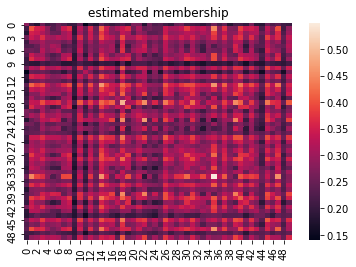

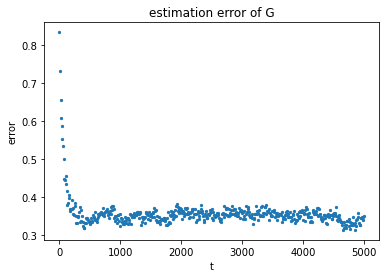

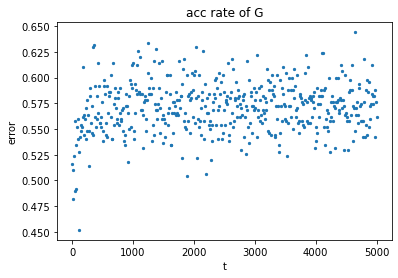

In [45]:
asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, 0.05, 10, nskip=10, nsave=500,a=a,rho = rho)
nsave = len(Gs)-1
nskip = 10
print("accept rate of a, G and rho for the last iteration:",arG[-1])
G1 = Gs[-1]
print("ave error G:", (abs(G-G1)).sum()/N)

differenceG = abs(G-G1).sum(axis=1)
error_summary_G = []
for tt in range(5,0,-1):
    tem = tt/10
    error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/50)
    print("P(difference<"+str(tem)+")=", error_summary_G[-1])

eU = sns.heatmap(np.dot(G1,G1.T))
plt.title("estimated membership")
plt.show()

errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
plt.scatter([i*nskip for i in range(nsave+1)], errorG, s=5)
plt.title("estimation error of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

plt.scatter([i*nskip for i in range(nsave+1)], arG, s=5)
plt.title("acc rate of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

accept rate of a, G and rho for the last iteration: 0.462
ave error G: 0.3731224733730016
P(difference<0.5)= 0.86
P(difference<0.4)= 0.64
P(difference<0.3)= 0.34
P(difference<0.2)= 0.1
P(difference<0.1)= 0.0


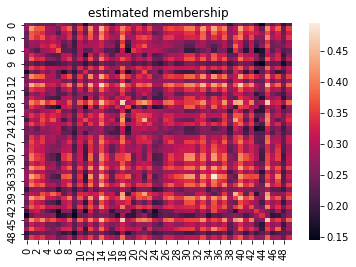

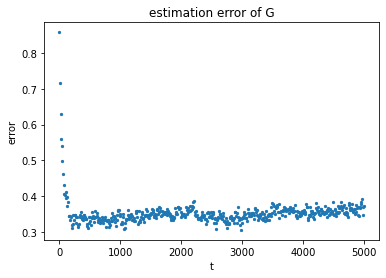

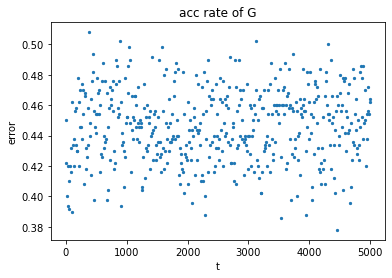

In [46]:
asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, 0.1, 10, nskip=10, nsave=500,a=a,rho = rho)
nsave = len(Gs)-1
nskip = 10
print("accept rate of a, G and rho for the last iteration:",arG[-1])
G1 = Gs[-1]
print("ave error G:", (abs(G-G1)).sum()/N)

differenceG = abs(G-G1).sum(axis=1)
error_summary_G = []
for tt in range(5,0,-1):
    tem = tt/10
    error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/50)
    print("P(difference<"+str(tem)+")=", error_summary_G[-1])

eU = sns.heatmap(np.dot(G1,G1.T))
plt.title("estimated membership")
plt.show()

errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
plt.scatter([i*nskip for i in range(nsave+1)], errorG, s=5)
plt.title("estimation error of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

plt.scatter([i*nskip for i in range(nsave+1)], arG, s=5)
plt.title("acc rate of G")
plt.xlabel("t")
plt.ylabel("error")
plt.show()

In [31]:
# let's analyze G[0], see why not accept
i = 0
g = G[i]
oldg = Gs[-1][i]
print("True G:",g)
print("estimate G:",oldg)
print("difference:",oldg-g)
print("relative difference:",(oldg-g)/g)
print("true px:",px(X[i], np.dot(T[Y[i]], g), s2, tao))
print("estimated px:",px(X[i], np.dot(T[Y[i]], oldg), s2, tao))
print("true pg:", ((a*rho-1)*np.log(g)).sum())
print("estimated pg:", ((a*rho-1)*np.log(oldg)).sum())

True G: [0.02615652 0.18859329 0.07783413 0.13422844 0.1796949  0.07425867
 0.31923404]
estimate G: [3.53401629e-02 2.51530912e-01 7.60734474e-03 2.69822541e-01
 1.74473499e-01 1.15786358e-04 2.61109754e-01]
difference: [ 0.00918365  0.06293762 -0.07022678  0.1355941  -0.0052214  -0.07414289
 -0.05812429]
relative difference: [ 0.35110357  0.3337214  -0.90226209  1.01017408 -0.02905704 -0.99844077
 -0.18207422]
true px: -17.25665615782183
estimated px: -13.093493816191739
true pg: -12.230369481059268
estimated pg: -9.890166906650094


In [34]:
i=0
infinity = 10**(-5)
sigmag = 0.001
oldg = Gs[-1][i]
oldpx = px(X[i], np.dot(T[Y[i]], oldg), s2, tao)
oldpg = ((a*rho-1)*np.log(oldg)).sum()
oldp = oldpg+oldpx
Caccept=Count=0
while int(input("continue?")):
    Count+=1
    newg = simplex_proposal(oldg, sigmag)
    if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
    newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
    newpg = ((a*rho-1)*np.log(newg)).sum()
    newp = newpx+newpg
    ag = min(1, np.exp(min(1,newp-oldp)))
    u = np.random.uniform()
    print("oldg:",oldg)
    print("newg:",newg)
    print(oldpx,oldpg,oldp)
    print(newpx,newpg,newp)
    print("u = ",u,", accept rate = ",ag)
    if u<ag:
        Caccept+=1
        print("accept!")
        oldg, oldpx,oldpg,oldp = newg,newpx,newpg,newp
    print("accept rate = ",Caccept/Count)

continue?1
oldg: [3.53401629e-02 2.51530912e-01 7.60734474e-03 2.69822541e-01
 1.74473499e-01 1.15786358e-04 2.61109754e-01]
newg: [3.45593955e-02 2.52368851e-01 8.00450954e-03 2.82547020e-01
 1.65000911e-01 1.17525270e-04 2.57401788e-01]
-13.093493816191739 -9.890166906650094 -22.983660722841833
-12.93251262007383 -9.938108468016878 -22.870621088090708
u =  0.27608989037460885 , accept rate =  1
accept!
accept rate =  1.0
continue?1
oldg: [3.45593955e-02 2.52368851e-01 8.00450954e-03 2.82547020e-01
 1.65000911e-01 1.17525270e-04 2.57401788e-01]
newg: [3.31937242e-02 2.62274467e-01 7.59659159e-03 2.88424555e-01
 1.58729663e-01 1.12331517e-04 2.49668669e-01]
-12.93251262007383 -9.938108468016878 -22.870621088090708
-13.05007525509412 -9.91048952063365 -22.960564775727768
u =  0.5464381291729269 , accept rate =  0.9139826523449379
accept!
accept rate =  1.0
continue?1
oldg: [3.31937242e-02 2.62274467e-01 7.59659159e-03 2.88424555e-01
 1.58729663e-01 1.12331517e-04 2.49668669e-01]
newg: [